In [1]:
from matplotlib import pyplot as plt
from sklearn import cluster, preprocessing
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings, cv2
warnings.filterwarnings('ignore')

In [2]:
def load_image(path, rgb=False):
    img = cv2.imread(path)
    if rgb:
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        
    return img

def contour_of_specific_color(image, color):
    mask = np.where((image[:, :, 0] == color[0]) &
                    (image[:, :, 1] == color[1]) &
                    (image[:, :, 2] == color[2]), 1, 0)
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    return contours

def to_geopandas(contours):
    def getPolyCoords(row, geom):
        exterior = row[geom].exterior
        return [(x, y) for x, y in zip(exterior.coords.xy[0], exterior.coords.xy[1])]

    def reverse_picture(polygon_coor):
        return [(point[0], - point[1]) for point in polygon_coor]

    def list_to_hexagon(polygon_coor):
        return Polygon(polygon_coor)
    
    Polygon_l = [Polygon(c[:, 0, :]) for c in contours if c.shape[0] > 2]
    data = {'id': [i for i in range(len(Polygon_l))]}
    crs = {'init' :'epsg:3826'}
    geometry = gpd.GeoSeries(Polygon_l)
    gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

    gdf['coor'] = gdf.apply(getPolyCoords, geom='geometry', axis=1)
    gdf['reverse_coor'] = gdf['coor'].apply(reverse_picture)
    gdf['geometry'] = gdf['reverse_coor'].apply(list_to_hexagon)
    return gdf

In [6]:
path = '/home/herry/hackthon/data/label/output_1.png'
img = load_image(path, rgb=True)
# color = (r, g, b)
contours = contour_of_specific_color(img, color=(1, 1, 1))
gdf = to_geopandas(contours)

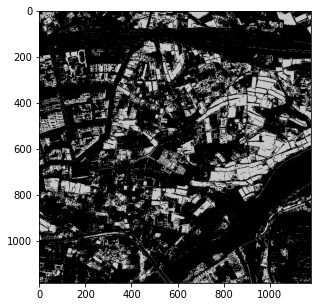

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(img*200)

<AxesSubplot:>

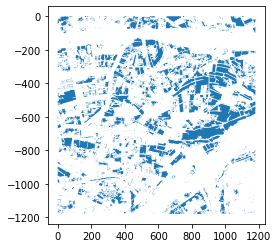

In [11]:
gdf.plot()